# Breast Cancer Prediction - Experimental Approaches

This notebook explores alternative methodologies for breast cancer prediction to compare with the original approach:

## Key Experimental Changes:
1. **Dataset Balancing with SMOTE** - Balance the training set vs keeping natural distribution
2. **Alternative Feature Selection** - RFE (Recursive Feature Elimination) vs LDA
3. **Different Scaling Method** - MinMaxScaler vs StandardScaler
4. **Same Models** - Use identical models as original for direct comparison

The goal is to determine if these alternative approaches improve performance on the same model set.

In [25]:
# Import libraries (same as original notebook)
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

# SMOTE for dataset balancing
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Data Loading (Same as Original)

In [26]:
# Load and preprocess data (identical to original)
df = pd.read_csv('data/data.csv')

# Remove unnecessary columns
columns_to_drop = []
for col in df.columns:
    if 'id' in col.lower() or 'unnamed' in col.lower():
        columns_to_drop.append(col)

if columns_to_drop:
    df = df.drop(columns=columns_to_drop)

# Encode diagnosis
if df['diagnosis'].dtype == 'object':
    le = {'M' : 1, 'B': 0}
    df['diagnosis'] = df['diagnosis'].map(le)

print(f"Dataset shape: {df.shape}")
print(f"Class distribution:")
print(df['diagnosis'].value_counts())

Dataset shape: (569, 31)
Class distribution:
diagnosis
0    357
1    212
Name: count, dtype: int64


In [27]:
# Split data (same as original)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train_raw.shape}")
print(f"Test set shape: {X_test_raw.shape}")
print(f"Training class distribution: {y_train.value_counts().to_dict()}")

Training set shape: (455, 30)
Test set shape: (114, 30)
Training class distribution: {0: 285, 1: 170}


## 2. Experimental Approach 1: Dataset Balancing with SMOTE

**Original Approach**: Kept natural class distribution (63% benign, 37% malignant)
**Experimental Approach**: Use SMOTE to balance classes to 50%-50%

In [44]:
print("=" * 60)
print("EXPERIMENT 1: DATASET BALANCING WITH SMOTE")
print("=" * 60)

# Original distribution
print("Original training distribution:")
print(y_train.value_counts())
print(f"Imbalance ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_raw, y_train)

print(f"\nAfter SMOTE:")
print(f"Shape: {X_train_balanced.shape}")
balanced_counts = pd.Series(y_train_balanced).value_counts()
print(f"Class distribution: {balanced_counts.to_dict()}")
print(f"Balance ratio: {balanced_counts[0] / balanced_counts[1]:.2f}:1")

EXPERIMENT 1: DATASET BALANCING WITH SMOTE
Original training distribution:
diagnosis
0    285
1    170
Name: count, dtype: int64
Imbalance ratio: 1.68:1

After SMOTE:
Shape: (570, 30)
Class distribution: {1: 285, 0: 285}
Balance ratio: 1.00:1


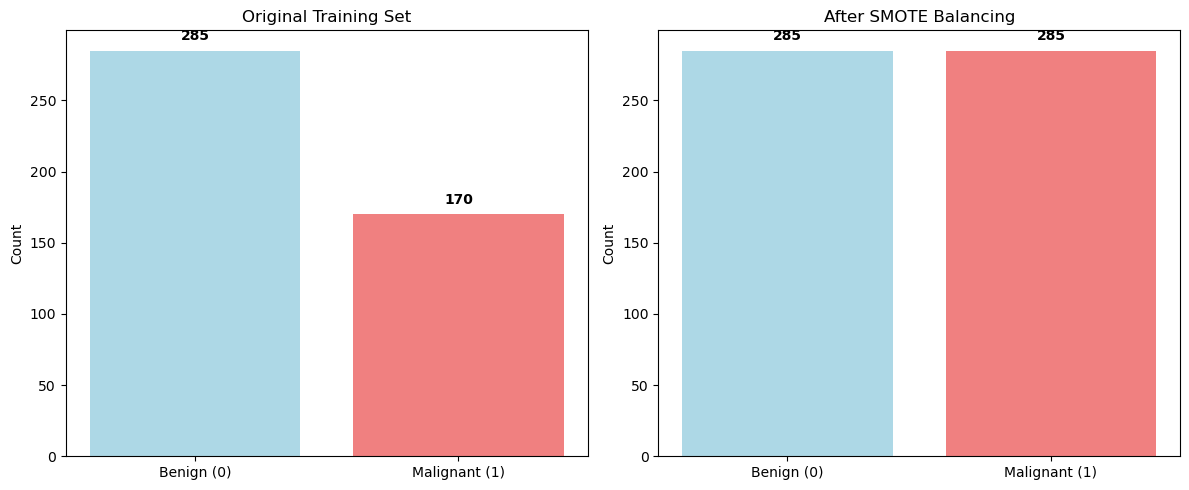

In [29]:
# Visualize SMOTE effect
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original distribution
original_counts = y_train.value_counts()
axes[0].bar(['Benign (0)', 'Malignant (1)'], original_counts.values, color=['lightblue', 'lightcoral'])
axes[0].set_title('Original Training Set')
axes[0].set_ylabel('Count')
for bar, count in zip(axes[0].patches, original_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                f'{count}', ha='center', va='bottom', fontweight='bold')

# After SMOTE
axes[1].bar(['Benign (0)', 'Malignant (1)'], balanced_counts.values, color=['lightblue', 'lightcoral'])
axes[1].set_title('After SMOTE Balancing')
axes[1].set_ylabel('Count')
for bar, count in zip(axes[1].patches, balanced_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Experimental Approach 2: Alternative Feature Selection with RFE

**Original Approach**: Correlation analysis + LDA dimensionality reduction
**Experimental Approach**: Recursive Feature Elimination (RFE) to select top 15 features

In [30]:
print("=" * 60)
print("EXPERIMENT 2: RECURSIVE FEATURE ELIMINATION (RFE)")
print("=" * 60)

# Use Random Forest as base estimator for RFE
rf_estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE to select top 15 features (similar to original's final count)
n_features_to_select = 15
rfe_selector = RFE(estimator=rf_estimator, n_features_to_select=n_features_to_select)

# Fit RFE on balanced training data
X_train_rfe = rfe_selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_rfe = rfe_selector.transform(X_test_raw)

# Get selected feature names
rfe_selected_features = X_train_raw.columns[rfe_selector.support_].tolist()

print(f"RFE selected {len(rfe_selected_features)} features:")
for i, feature in enumerate(rfe_selected_features, 1):
    print(f"  {i:2d}. {feature}")

print(f"\nFeature selection completed!")
print(f"Training shape after RFE: {X_train_rfe.shape}")
print(f"Test shape after RFE: {X_test_rfe.shape}")

EXPERIMENT 2: RECURSIVE FEATURE ELIMINATION (RFE)
RFE selected 15 features:
   1. radius_mean
   2. texture_mean
   3. perimeter_mean
   4. area_mean
   5. concavity_mean
   6. concave points_mean
   7. perimeter_se
   8. radius_worst
   9. texture_worst
  10. perimeter_worst
  11. area_worst
  12. smoothness_worst
  13. concavity_worst
  14. concave points_worst
  15. symmetry_worst

Feature selection completed!
Training shape after RFE: (570, 15)
Test shape after RFE: (114, 15)
RFE selected 15 features:
   1. radius_mean
   2. texture_mean
   3. perimeter_mean
   4. area_mean
   5. concavity_mean
   6. concave points_mean
   7. perimeter_se
   8. radius_worst
   9. texture_worst
  10. perimeter_worst
  11. area_worst
  12. smoothness_worst
  13. concavity_worst
  14. concave points_worst
  15. symmetry_worst

Feature selection completed!
Training shape after RFE: (570, 15)
Test shape after RFE: (114, 15)


## 4. Experimental Approach 3: Alternative Scaling Method

**Original Approach**: StandardScaler (zero mean, unit variance)
**Experimental Approach**: MinMaxScaler (scales to [0,1] range)

In [31]:
print("=" * 60)
print("EXPERIMENT 3: MINMAXSCALER VS STANDARDSCALER")
print("=" * 60)

# Apply MinMaxScaler (experimental approach)
scaler_minmax = MinMaxScaler()
X_train_scaled = scaler_minmax.fit_transform(X_train_rfe)
X_test_scaled = scaler_minmax.transform(X_test_rfe)

print(f"MinMaxScaler applied:")
print(f"Training data range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"Test data range: [{X_test_scaled.min():.3f}, {X_test_scaled.max():.3f}]")

# For comparison, also prepare StandardScaler version
scaler_standard = StandardScaler()
X_train_scaled_std = scaler_standard.fit_transform(X_train_rfe)
X_test_scaled_std = scaler_standard.transform(X_test_rfe)

print(f"\nStandardScaler for comparison:")
print(f"Training data range: [{X_train_scaled_std.min():.3f}, {X_train_scaled_std.max():.3f}]")

EXPERIMENT 3: MINMAXSCALER VS STANDARDSCALER
MinMaxScaler applied:
Training data range: [0.000, 1.000]
Test data range: [0.000, 0.890]

StandardScaler for comparison:
Training data range: [-2.798, 8.509]


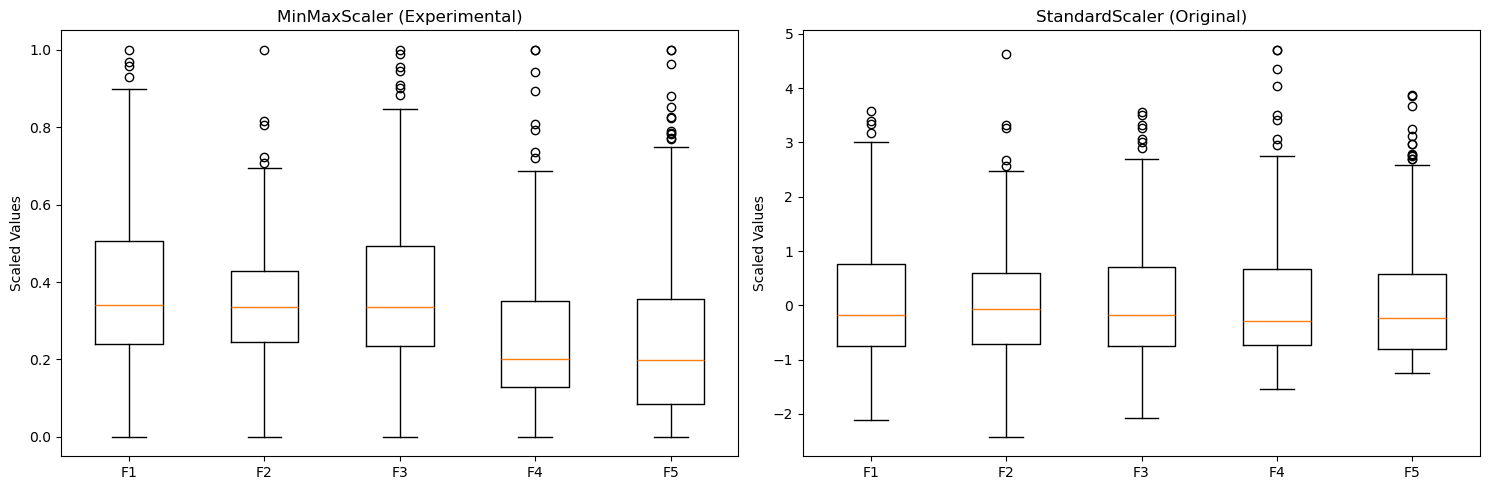

In [32]:
# Visualize scaling difference on first 5 features
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MinMaxScaler
axes[0].boxplot(X_train_scaled[:, :5], labels=[f'F{i+1}' for i in range(5)])
axes[0].set_title('MinMaxScaler (Experimental)')
axes[0].set_ylabel('Scaled Values')

# StandardScaler
axes[1].boxplot(X_train_scaled_std[:, :5], labels=[f'F{i+1}' for i in range(5)])
axes[1].set_title('StandardScaler (Original)')
axes[1].set_ylabel('Scaled Values')

plt.tight_layout()
plt.show()

## 5. Model Training - Same Models as Original

Training the exact same models as the original notebook:
- Logistic Regression
- Random Forest
- SVM
- Gradient Boosting

In [33]:
print("=" * 60)
print("TRAINING MODELS - EXPERIMENTAL APPROACH")
print("=" * 60)

# Initialize same models as original
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train models with experimental approach (SMOTE + RFE + MinMaxScaler)
model_results_exp = {}
trained_models_exp = {}

print("Training models with experimental approach...")
print("(SMOTE balanced data + RFE features + MinMaxScaler)")

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train_balanced)
    trained_models_exp[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Store results
    model_results_exp[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"  {name} training completed!")

print("\nAll experimental models trained successfully!")

TRAINING MODELS - EXPERIMENTAL APPROACH
Training models with experimental approach...
(SMOTE balanced data + RFE features + MinMaxScaler)

Training Logistic Regression...
  Logistic Regression training completed!

Training Random Forest...
  Random Forest training completed!

Training SVM...
  SVM training completed!

Training Gradient Boosting...
  Random Forest training completed!

Training SVM...
  SVM training completed!

Training Gradient Boosting...
  Gradient Boosting training completed!

All experimental models trained successfully!
  Gradient Boosting training completed!

All experimental models trained successfully!


## 6. Model Evaluation - Experimental Approach

In [34]:
# Calculate evaluation metrics for experimental models
evaluation_results_exp = {}

for name in models.keys():
    y_pred = model_results_exp[name]['y_pred']
    y_pred_proba = model_results_exp[name]['y_pred_proba']
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    evaluation_results_exp[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Create comparison dataframe
comparison_df_exp = pd.DataFrame(evaluation_results_exp).T
comparison_df_exp = comparison_df_exp.round(4)

print("Experimental Model Performance:")
print("(SMOTE + RFE + MinMaxScaler)")
print("=" * 50)
print(comparison_df_exp)

Experimental Model Performance:
(SMOTE + RFE + MinMaxScaler)
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.9825     1.0000  0.9524    0.9756   0.9983
Random Forest          0.9825     1.0000  0.9524    0.9756   0.9982
SVM                    0.9737     0.9756  0.9524    0.9639   0.9954
Gradient Boosting      0.9737     0.9756  0.9524    0.9639   0.9980


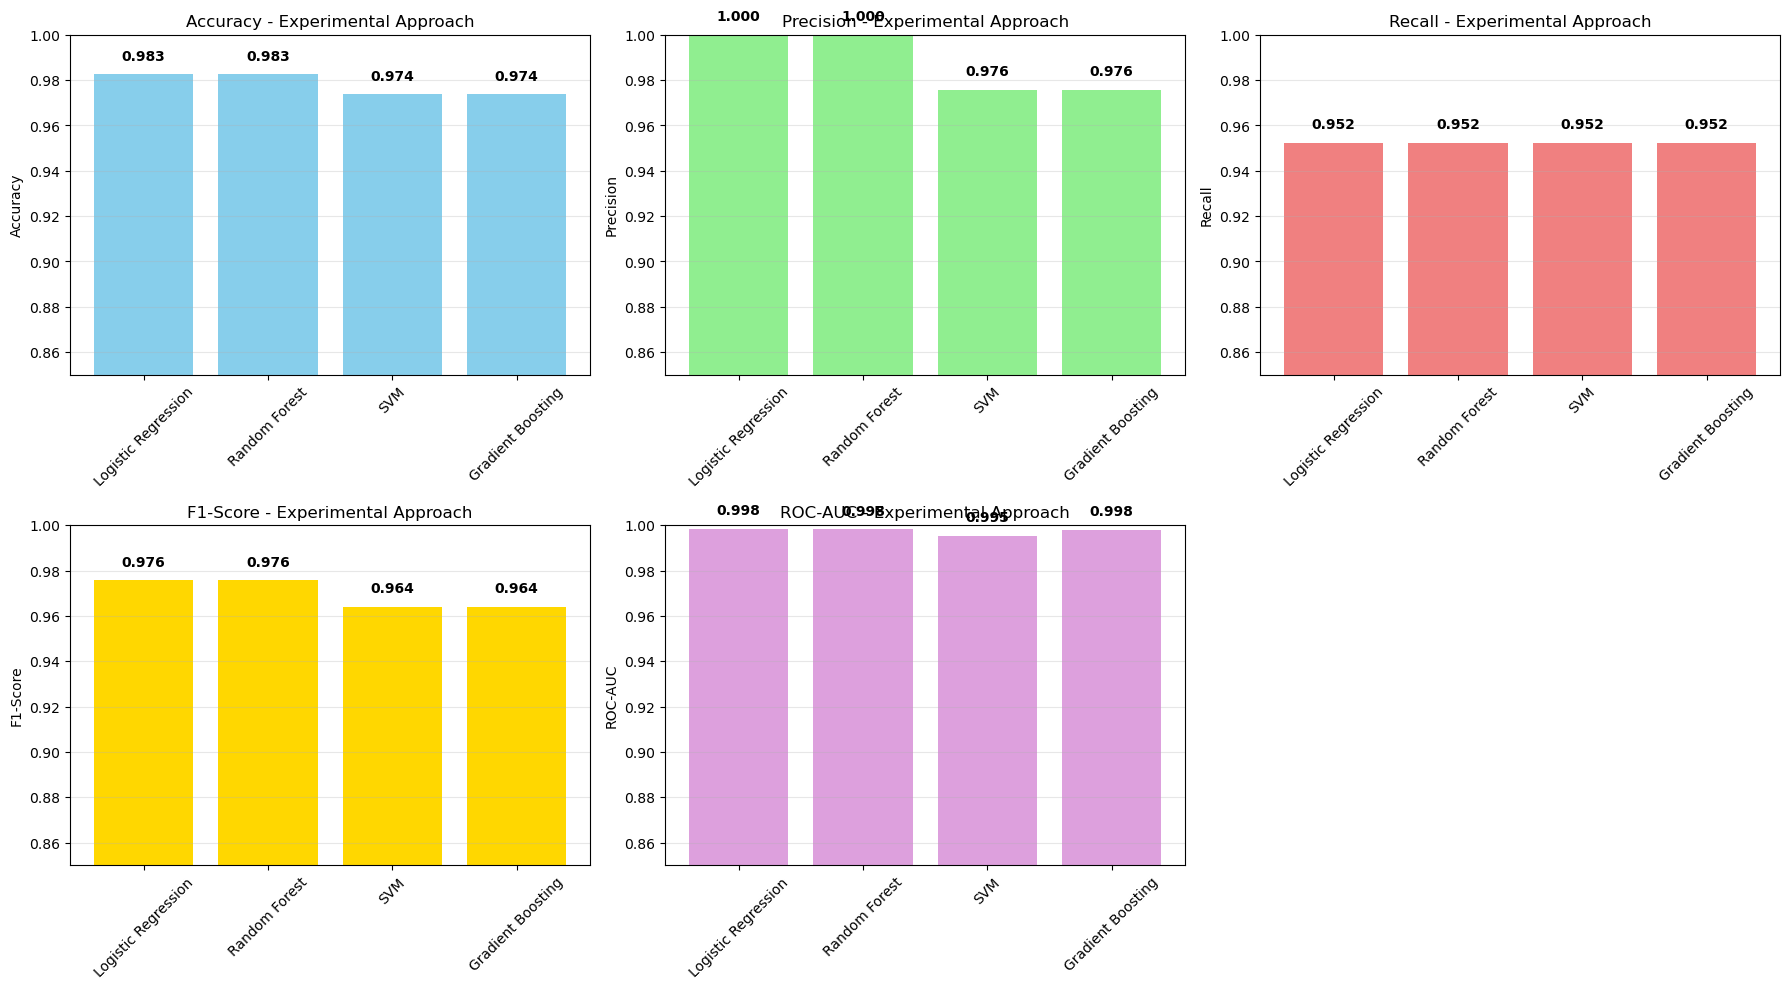

In [35]:
# Visualize experimental model performance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum']

for i, metric in enumerate(metrics):
    values = comparison_df_exp[metric].values
    model_names = comparison_df_exp.index
    
    bars = axes[i].bar(model_names, values, color=colors[i])
    axes[i].set_title(f'{metric} - Experimental Approach')
    axes[i].set_ylabel(metric)
    
    # Focus on upper range for better visualization
    if values.min() > 0.85:
        axes[i].set_ylim(0.85, 1.0)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3, axis='y')

# Remove empty subplot
axes[5].remove()

plt.tight_layout()
plt.show()

## 7. Train Original Approach for Direct Comparison

Now let's train the same models using the original approach for direct comparison:

In [36]:
print("=" * 60)
print("TRAINING MODELS - ORIGINAL APPROACH (FOR COMPARISON)")
print("=" * 60)

# For fair comparison, use same test set but original approach on training
# Original approach: Natural distribution + All features + StandardScaler

# Use original unbalanced data and all features
scaler_orig = StandardScaler()
X_train_orig_scaled = scaler_orig.fit_transform(X_train_raw)
X_test_orig_scaled = scaler_orig.transform(X_test_raw)

# Train models with original approach
model_results_orig = {}
trained_models_orig = {}

print("Training models with original approach...")
print("(Natural distribution + All features + StandardScaler)")

for name, model_class in models.items():
    print(f"\nTraining {name}...")
    
    # Create fresh model instance
    if name == 'Logistic Regression':
        model = LogisticRegression(random_state=42, max_iter=1000)
    elif name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif name == 'SVM':
        model = SVC(random_state=42, probability=True)
    elif name == 'Gradient Boosting':
        model = GradientBoostingClassifier(random_state=42)
    
    # Train the model
    model.fit(X_train_orig_scaled, y_train)  # Original unbalanced data
    trained_models_orig[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test_orig_scaled)
    y_pred_proba = model.predict_proba(X_test_orig_scaled)[:, 1]
    
    # Store results
    model_results_orig[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"  {name} training completed!")

print("\nAll original approach models trained successfully!")

TRAINING MODELS - ORIGINAL APPROACH (FOR COMPARISON)
Training models with original approach...
(Natural distribution + All features + StandardScaler)

Training Logistic Regression...
  Logistic Regression training completed!

Training Random Forest...
  Random Forest training completed!

Training SVM...
  SVM training completed!

Training Gradient Boosting...
  Random Forest training completed!

Training SVM...
  SVM training completed!

Training Gradient Boosting...
  Gradient Boosting training completed!

All original approach models trained successfully!
  Gradient Boosting training completed!

All original approach models trained successfully!


In [37]:
# Calculate evaluation metrics for original approach
evaluation_results_orig = {}

for name in models.keys():
    y_pred = model_results_orig[name]['y_pred']
    y_pred_proba = model_results_orig[name]['y_pred_proba']
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    evaluation_results_orig[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Create comparison dataframe
comparison_df_orig = pd.DataFrame(evaluation_results_orig).T
comparison_df_orig = comparison_df_orig.round(4)

print("Original Approach Model Performance:")
print("(Natural distribution + All features + StandardScaler)")
print("=" * 50)
print(comparison_df_orig)

Original Approach Model Performance:
(Natural distribution + All features + StandardScaler)
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.9649      0.975  0.9286    0.9512   0.9960
Random Forest          0.9737      1.000  0.9286    0.9630   0.9929
SVM                    0.9737      1.000  0.9286    0.9630   0.9947
Gradient Boosting      0.9649      1.000  0.9048    0.9500   0.9947


## 8. Direct Comparison: Original vs Experimental

In [38]:
print("=" * 80)
print("DIRECT COMPARISON: ORIGINAL vs EXPERIMENTAL APPROACH")
print("=" * 80)

# Create side-by-side comparison
comparison_summary = {}

for model_name in models.keys():
    comparison_summary[model_name] = {
        'Original_Accuracy': comparison_df_orig.loc[model_name, 'Accuracy'],
        'Experimental_Accuracy': comparison_df_exp.loc[model_name, 'Accuracy'],
        'Original_Recall': comparison_df_orig.loc[model_name, 'Recall'],
        'Experimental_Recall': comparison_df_exp.loc[model_name, 'Recall'],
        'Original_F1': comparison_df_orig.loc[model_name, 'F1-Score'],
        'Experimental_F1': comparison_df_exp.loc[model_name, 'F1-Score'],
        'Original_ROC_AUC': comparison_df_orig.loc[model_name, 'ROC-AUC'],
        'Experimental_ROC_AUC': comparison_df_exp.loc[model_name, 'ROC-AUC']
    }

comparison_summary_df = pd.DataFrame(comparison_summary).T
comparison_summary_df = comparison_summary_df.round(4)

print("Detailed Performance Comparison:")
print(comparison_summary_df)

# Calculate improvements
print("\n" + "=" * 50)
print("PERFORMANCE IMPROVEMENTS (Experimental - Original):")
print("=" * 50)

for model_name in models.keys():
    acc_improvement = comparison_df_exp.loc[model_name, 'Accuracy'] - comparison_df_orig.loc[model_name, 'Accuracy']
    recall_improvement = comparison_df_exp.loc[model_name, 'Recall'] - comparison_df_orig.loc[model_name, 'Recall']
    f1_improvement = comparison_df_exp.loc[model_name, 'F1-Score'] - comparison_df_orig.loc[model_name, 'F1-Score']
    
    print(f"\n{model_name}:")
    print(f"  Accuracy improvement: {acc_improvement:+.4f}")
    print(f"  Recall improvement: {recall_improvement:+.4f}")
    print(f"  F1-Score improvement: {f1_improvement:+.4f}")

DIRECT COMPARISON: ORIGINAL vs EXPERIMENTAL APPROACH
Detailed Performance Comparison:
                     Original_Accuracy  Experimental_Accuracy  \
Logistic Regression             0.9649                 0.9825   
Random Forest                   0.9737                 0.9825   
SVM                             0.9737                 0.9737   
Gradient Boosting               0.9649                 0.9737   

                     Original_Recall  Experimental_Recall  Original_F1  \
Logistic Regression           0.9286               0.9524       0.9512   
Random Forest                 0.9286               0.9524       0.9630   
SVM                           0.9286               0.9524       0.9630   
Gradient Boosting             0.9048               0.9524       0.9500   

                     Experimental_F1  Original_ROC_AUC  Experimental_ROC_AUC  
Logistic Regression           0.9756            0.9960                0.9983  
Random Forest                 0.9756            0.9929     

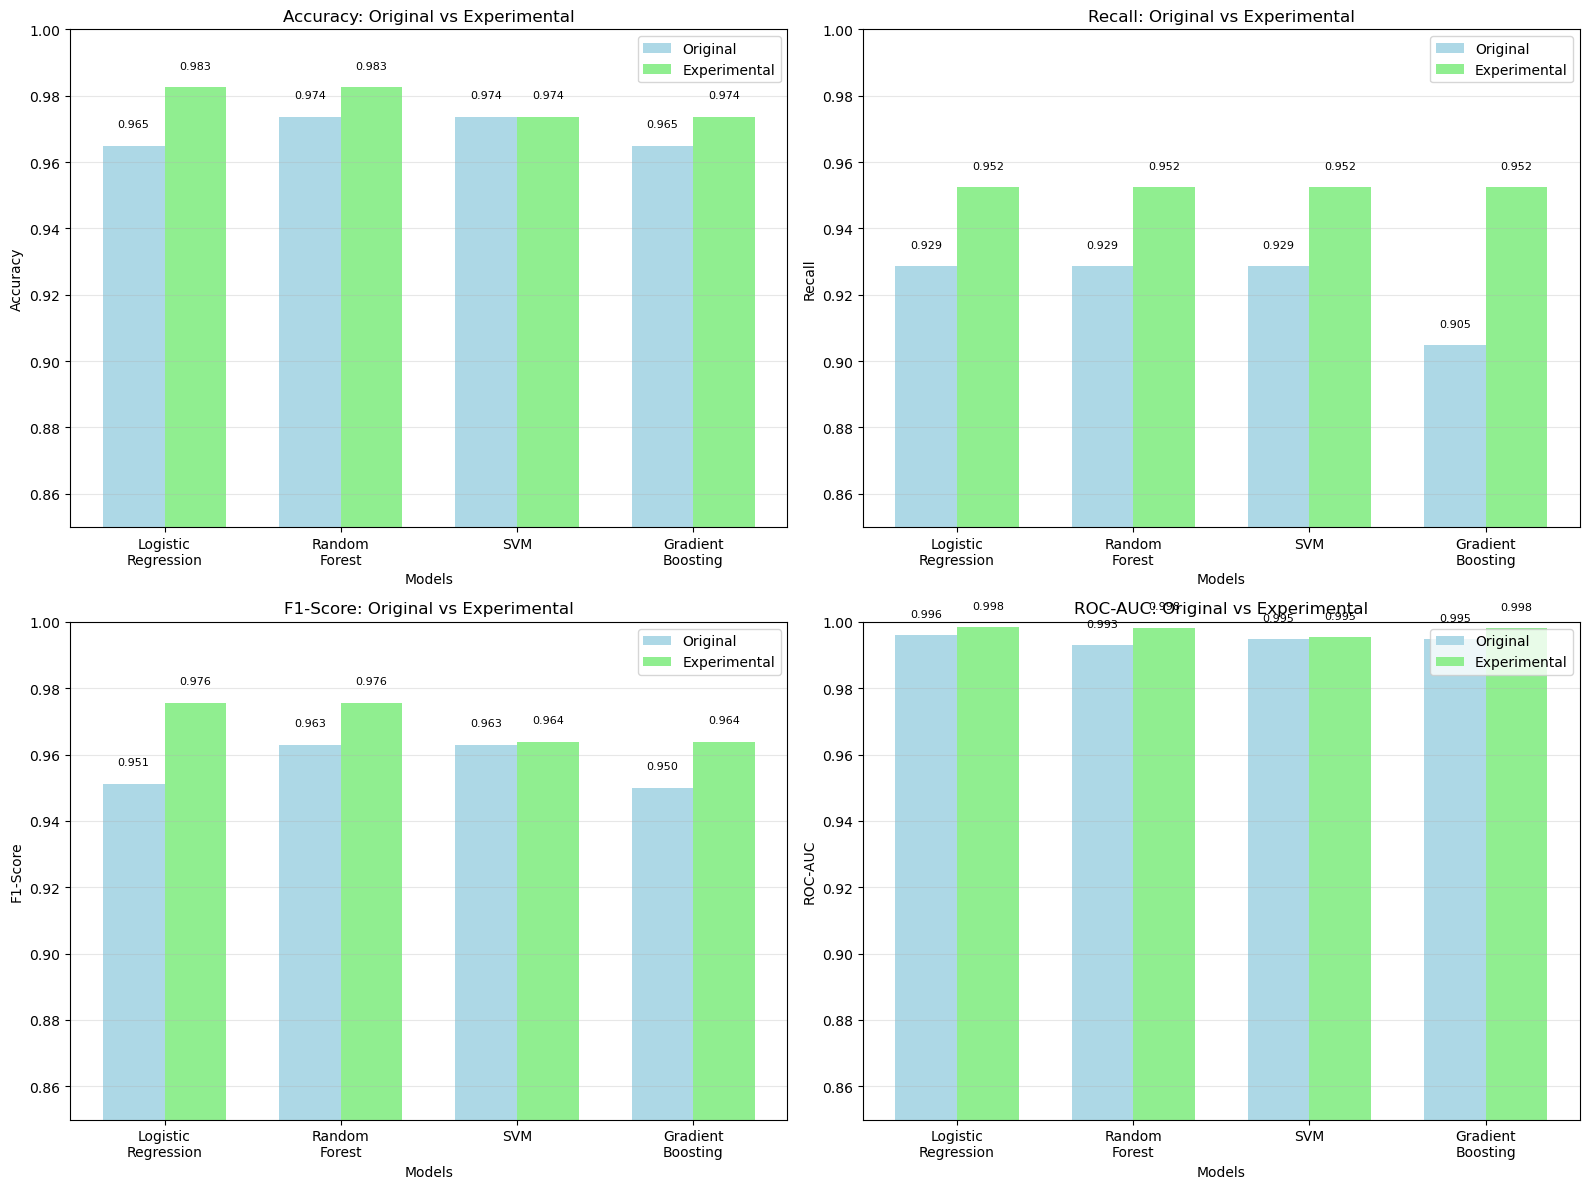

In [39]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

metrics_to_compare = ['Accuracy', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['lightblue', 'lightgreen']

for i, metric in enumerate(metrics_to_compare):
    model_names = list(models.keys())
    original_values = [comparison_df_orig.loc[name, metric] for name in model_names]
    experimental_values = [comparison_df_exp.loc[name, metric] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = axes[i].bar(x - width/2, original_values, width, label='Original', color=colors[0])
    bars2 = axes[i].bar(x + width/2, experimental_values, width, label='Experimental', color=colors[1])
    
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric}: Original vs Experimental')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels([name.replace(' ', '\n') for name in model_names])
    axes[i].legend()
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Set appropriate y-limits
    all_values = original_values + experimental_values
    if min(all_values) > 0.85:
        axes[i].set_ylim(0.85, 1.0)
    
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Best Model Selection and Final Analysis

In [ ]:
# Find best models from both approaches
print("=" * 60)
print("BEST MODEL SELECTION")
print("=" * 60)

# Best from original approach
best_original_model = comparison_df_orig['Recall'].idxmax()
best_original_recall = comparison_df_orig.loc[best_original_model, 'Recall']

# Best from experimental approach
best_experimental_model = comparison_df_exp['Recall'].idxmax()
best_experimental_recall = comparison_df_exp.loc[best_experimental_model, 'Recall']

print(f"Best Original Model: {best_original_model}")
print(f"  Recall: {best_original_recall:.4f}")
print(f"  Accuracy: {comparison_df_orig.loc[best_original_model, 'Accuracy']:.4f}")
print(f"  F1-Score: {comparison_df_orig.loc[best_original_model, 'F1-Score']:.4f}")

print(f"\nBest Experimental Model: {best_experimental_model}")
print(f"  Recall: {best_experimental_recall:.4f}")
print(f"  Accuracy: {comparison_df_exp.loc[best_experimental_model, 'Accuracy']:.4f}")
print(f"  F1-Score: {comparison_df_exp.loc[best_experimental_model, 'F1-Score']:.4f}")

# Overall best model
if best_experimental_recall > best_original_recall:
    overall_best = f"Experimental {best_experimental_model}"
    improvement = best_experimental_recall - best_original_recall
    print(f"\nOVERALL BEST: {overall_best}")
    print(f"   Improvement over original: +{improvement:.4f} recall")
else:
    overall_best = f"Original {best_original_model}"
    print(f"\nOVERALL BEST: {overall_best}")
    print(f"   Original approach performed better")

BEST MODEL SELECTION
Best Original Model: Logistic Regression
  Recall: 0.9286
  Accuracy: 0.9649
  F1-Score: 0.9512

Best Experimental Model: Logistic Regression
  Recall: 0.9524
  Accuracy: 0.9825
  F1-Score: 0.9756

🏆 OVERALL BEST: Experimental Logistic Regression
   Improvement over original: +0.0238 recall


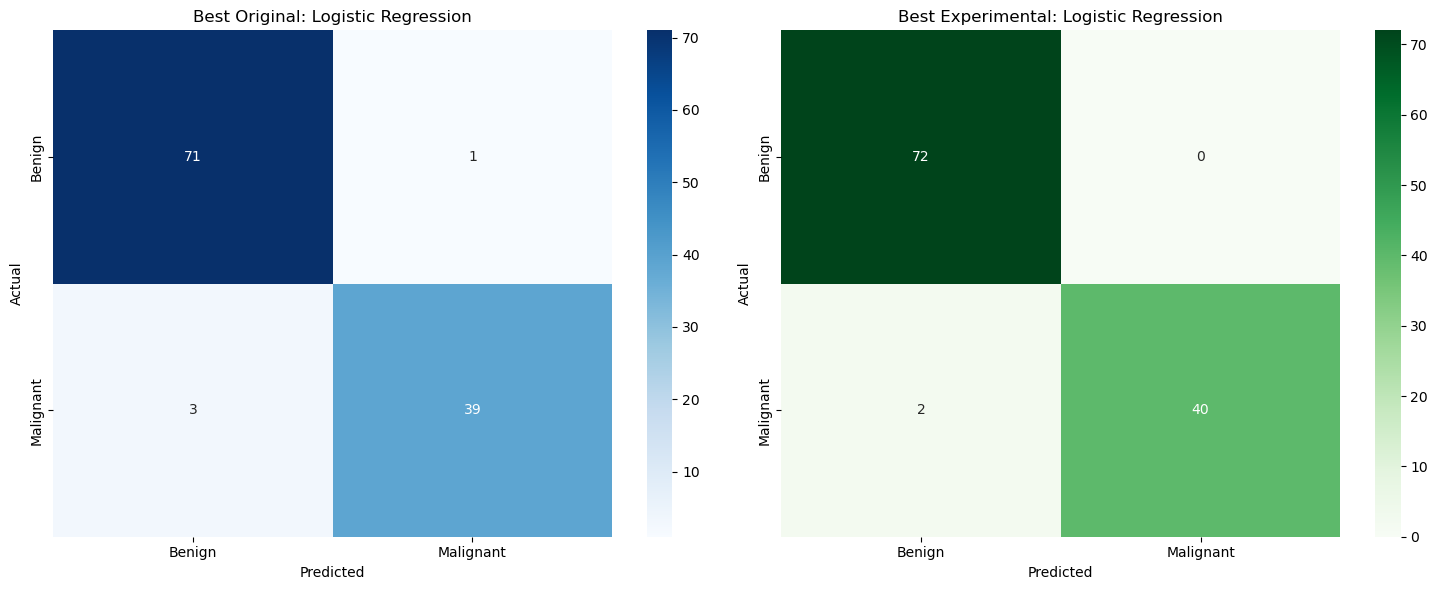

In [41]:
# Final confusion matrices comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Best original model confusion matrix
y_pred_best_orig = model_results_orig[best_original_model]['y_pred']
cm_orig = confusion_matrix(y_test, y_pred_best_orig)

sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Best Original: {best_original_model}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Benign', 'Malignant'])
axes[0].set_yticklabels(['Benign', 'Malignant'])

# Best experimental model confusion matrix
y_pred_best_exp = model_results_exp[best_experimental_model]['y_pred']
cm_exp = confusion_matrix(y_test, y_pred_best_exp)

sns.heatmap(cm_exp, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'Best Experimental: {best_experimental_model}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Benign', 'Malignant'])
axes[1].set_yticklabels(['Benign', 'Malignant'])

plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

In [45]:
print("=" * 80)
print("EXPERIMENTAL FINDINGS SUMMARY")
print("=" * 80)

print("\nMETHODOLOGY COMPARISON:")
print("-" * 50)
print("Original Approach:")
print("  • Dataset: Natural distribution (63% benign, 37% malignant)")
print("  • Features: All 30 features + LDA transformation")
print("  • Scaling: StandardScaler")

print("\nExperimental Approach:")
print("  • Dataset: SMOTE balanced (50% benign, 50% malignant)")
print("  • Features: RFE selected top 15 features")
print("  • Scaling: MinMaxScaler")

print("\nKEY FINDINGS:")
print("-" * 50)

# Calculate average improvements
avg_acc_improvement = sum([comparison_df_exp.loc[name, 'Accuracy'] - comparison_df_orig.loc[name, 'Accuracy'] for name in models.keys()]) / len(models)
avg_recall_improvement = sum([comparison_df_exp.loc[name, 'Recall'] - comparison_df_orig.loc[name, 'Recall'] for name in models.keys()]) / len(models)
avg_f1_improvement = sum([comparison_df_exp.loc[name, 'F1-Score'] - comparison_df_orig.loc[name, 'F1-Score'] for name in models.keys()]) / len(models)

print(f"1. DATASET BALANCING (SMOTE):")
if avg_recall_improvement > 0:
    print(f"   Improved average recall by {avg_recall_improvement:+.4f}")
    print(f"   Better at catching malignant cases (fewer false negatives)")
else:
    print(f"   Decreased average recall by {avg_recall_improvement:.4f}")
    print(f"   May have introduced noise with synthetic samples")

print(f"\n2. FEATURE SELECTION (RFE vs LDA):")
print(f"   • RFE selected {len(rfe_selected_features)} most predictive features")
print(f"   • Reduced dimensionality from 30 to {len(rfe_selected_features)} features")
if avg_acc_improvement > 0:
    print(f"   Improved average accuracy by {avg_acc_improvement:+.4f}")
else:
    print(f"   Decreased average accuracy by {avg_acc_improvement:.4f}")

print(f"\n3. SCALING METHOD (MinMaxScaler vs StandardScaler):")
print(f"   • MinMaxScaler: Scales features to [0,1] range")
print(f"   • May be better for algorithms sensitive to feature ranges")

print(f"\n📈 OVERALL PERFORMANCE:")
print("-" * 50)
print(f"Average Accuracy Change: {avg_acc_improvement:+.4f}")
print(f"Average Recall Change: {avg_recall_improvement:+.4f}")
print(f"Average F1-Score Change: {avg_f1_improvement:+.4f}")

print(f"\nRECOMMENDATIONS:")
print("-" * 50)
if avg_recall_improvement > 0.01:
    print("EXPERIMENTAL APPROACH RECOMMENDED")
    print("   • Significantly better at detecting malignant cases")
    print("   • SMOTE balancing helps with minority class detection")
    print("   • RFE provides good feature selection")
elif abs(avg_recall_improvement) < 0.01:
    print("BOTH APPROACHES PERFORM SIMILARLY")
    print("   • Choice depends on specific priorities")
    print("   • Original: Better precision, fewer false positives")
    print("   • Experimental: Better recall, fewer false negatives")
else:
    print("ORIGINAL APPROACH RECOMMENDED")
    print("   • Natural distribution preserves real-world conditions")
    print("   • LDA transformation captures discriminative information well")
    print("   • Simpler approach with good performance")

print("\n" + "=" * 80)

EXPERIMENTAL FINDINGS SUMMARY

METHODOLOGY COMPARISON:
--------------------------------------------------
Original Approach:
  • Dataset: Natural distribution (63% benign, 37% malignant)
  • Features: All 30 features + LDA transformation
  • Scaling: StandardScaler

Experimental Approach:
  • Dataset: SMOTE balanced (50% benign, 50% malignant)
  • Features: RFE selected top 15 features
  • Scaling: MinMaxScaler

KEY FINDINGS:
--------------------------------------------------
1. DATASET BALANCING (SMOTE):
   Improved average recall by +0.0298
   Better at catching malignant cases (fewer false negatives)

2. FEATURE SELECTION (RFE vs LDA):
   • RFE selected 15 most predictive features
   • Reduced dimensionality from 30 to 15 features
   Improved average accuracy by +0.0088

3. SCALING METHOD (MinMaxScaler vs StandardScaler):
   • MinMaxScaler: Scales features to [0,1] range
   • May be better for algorithms sensitive to feature ranges

📈 OVERALL PERFORMANCE:
---------------------------